# SBI experiments: an introduction

In this notebook, we will introduce three major Simulation-based inference algorithms powered by neural networks. We will use them to perform Bayesian inference on the toy example of estimating the centre of a multivariate normal distribution.

All methods used here will be implemented on top of [Pytorch](https://pytorch.org/), a popular Python package used for performing GPU-accelerated computations with tensors (a.k.a multi-dimensional arrays) as well as for building neural network models.

We will use the SBI algorithms' implementations from the [`sbi` package](https://sbi-dev.github.io/sbi/), which uses Pytorch under the hood.

## The model

We will choose a model where both parameters and data are sampled from a multivariate normal distribution.

The parameters $\boldsymbol{\theta} \in \mathbb{R}^n$ are sampled from

$$ \boldsymbol{\theta} \sim \mathcal{N}(\mu=\boldsymbol{0}_n, \Sigma_1=\sigma \boldsymbol{I}_n),$$

where $\sigma > 0$, $\boldsymbol{I}_n$ is the n x n identity matrix and $\boldsymbol{0}_n = \begin{pmatrix} 0 & \ldots & 0 \end{pmatrix}^T \in \mathbb{R}^n$. The data $\boldsymbol{x} \in \mathbb{R}^n$ are generated as follows:

$$ \boldsymbol{x} \sim \mathcal{N}(\mu=\boldsymbol{\theta}, \Sigma_2=\sigma \boldsymbol{I}_n) $$

We hereafter fix $\sigma = 0.01$.

### The analytical posterior

The posterior distribution can be calculated analytically for this case. Ignoring normalization factors and terms independent of $\boldsymbol{\theta}$, we can write

\begin{align*}
\log p(\boldsymbol{\theta} | \boldsymbol{x}) &\propto -\frac{1}{2}(\boldsymbol{x} - \boldsymbol{\theta})^T \Sigma^{-1}_2 (\boldsymbol{x} -\boldsymbol{\theta}) - \frac{1}{2}\boldsymbol{\theta}^T \Sigma^{-1}_1 \boldsymbol{\theta}\\
&\propto \boldsymbol{\theta}^T \Sigma^{-1}_2 \boldsymbol{x} - \frac{1}{2}\boldsymbol{\theta}^T(\Sigma^{-1}_1 + \Sigma^{-1}_2)\boldsymbol
{\theta},
\end{align*}

which, after completing the square, is found to follow a multivariate normal $\mathcal{N}(\mu, \Sigma_T)$ distribution of mean and convariance matrix

$$ \Sigma_T = (\Sigma_1^{-1} + \Sigma_2^{-1})^{-1} = \frac{\sigma}{2} \boldsymbol{I}_n$$

$$ \mu = \Sigma_T \Sigma^{-1}_2 \boldsymbol{x} = \frac{\boldsymbol{x}}{2},$$

the last equality being valid when $\Sigma_1 = \Sigma_2$.



In [1]:
# Uncomment the line below to install the package in Google colab
#!pip install git+https://github.com/binado/sbisandbox.git

In [2]:
import sys

sys.path.append("..")

import torch
from torch import Tensor
import arviz as az
from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-whitegrid")

/Users/bernardoveronese/miniconda3/envs/sbibench/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


### Implementing the model

The main ingredient for SBI is the simulator, which serves as a forward model from input parameters $\boldsymbol{\theta}$ to data samples $\boldsymbol{x}$. If the input are drawn from a proposal distribution $\boldsymbol{\theta}$, the simulator implicitly defines the mapping $\boldsymbol{x} \sim p(\boldsymbol{x} | \boldsymbol{\theta})$.

We implement the gaussian model in the two functions below. Multi-dimensional arrays, or tensors, are represented in Pytorch with the `torch.tensor` object, which is very similar to Numpy's `ndarray`, while also having support for running on GPUs.

In [3]:
ndim = 5  # You can change the number of dimensions
seed = 1998
torch.manual_seed(seed)

In [5]:
from torch.distributions import Distribution, MultivariateNormal

cov = 0.01
theta_loc = torch.zeros(ndim)
theta_precision_matrix = torch.eye(ndim) / cov
x_precision_matrix = torch.eye(ndim) / cov


def get_prior() -> Distribution:
    # Return the prior distribution
    return MultivariateNormal(loc=theta_loc, precision_matrix=theta_precision_matrix)


def gaussian_linear_simulator(theta: Tensor) -> Tensor:
    # theta is a tensor of shape (num_samples, ndim)
    return MultivariateNormal(loc=theta, precision_matrix=x_precision_matrix).sample()


def get_true_distribution(x: Tensor) -> MultivariateNormal:
    precision_matrix = theta_precision_matrix + x_precision_matrix
    loc = torch.linalg.solve(precision_matrix, x_precision_matrix @ x.squeeze())
    return MultivariateNormal(loc=loc, precision_matrix=precision_matrix)


def log_prob(theta: Tensor, x: Tensor) -> Tensor:
    dist = get_true_distribution(x)
    return dist.log_prob(theta)


def get_true_posterior_samples(num_samples: int, x: Tensor) -> Tensor:
    # Return samples from the analytical posterior
    dist = get_true_distribution(x)
    return dist.expand((num_samples,)).sample()

Let us define some utility functions which are going to be convenient for generating plots based on our samples:

In [6]:
def get_labels_for_var(var: str, n: int):
    return list(map(lambda i: f"${var}_{{{i}}}$", range(1, n + 1)))


def tensor_to_dataset(labels, tensor):
    return dict(zip(labels, [tensor[..., i] for i in range(tensor.shape[-1])]))

In the cell below, we use the `process_prior` and `process_simulator` helper methods from `sbi` to convert the prior and simulator into functions whith the appropriate return types for the package. Alternatively, you may use the helper method `sbisandbox.utils.validate_model`.

In [7]:
prior = get_prior()
# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(gaussian_linear_simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

### Visualizing the data

Let us use the `simulate_for_sbi` helper method to generate samples of $\theta$ and $x$.

In [8]:
num_simulations = 1000
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=num_simulations)
theta.shape, x.shape

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

(torch.Size([1000, 5]), torch.Size([1000, 5]))

Density plots for our parameter samples:

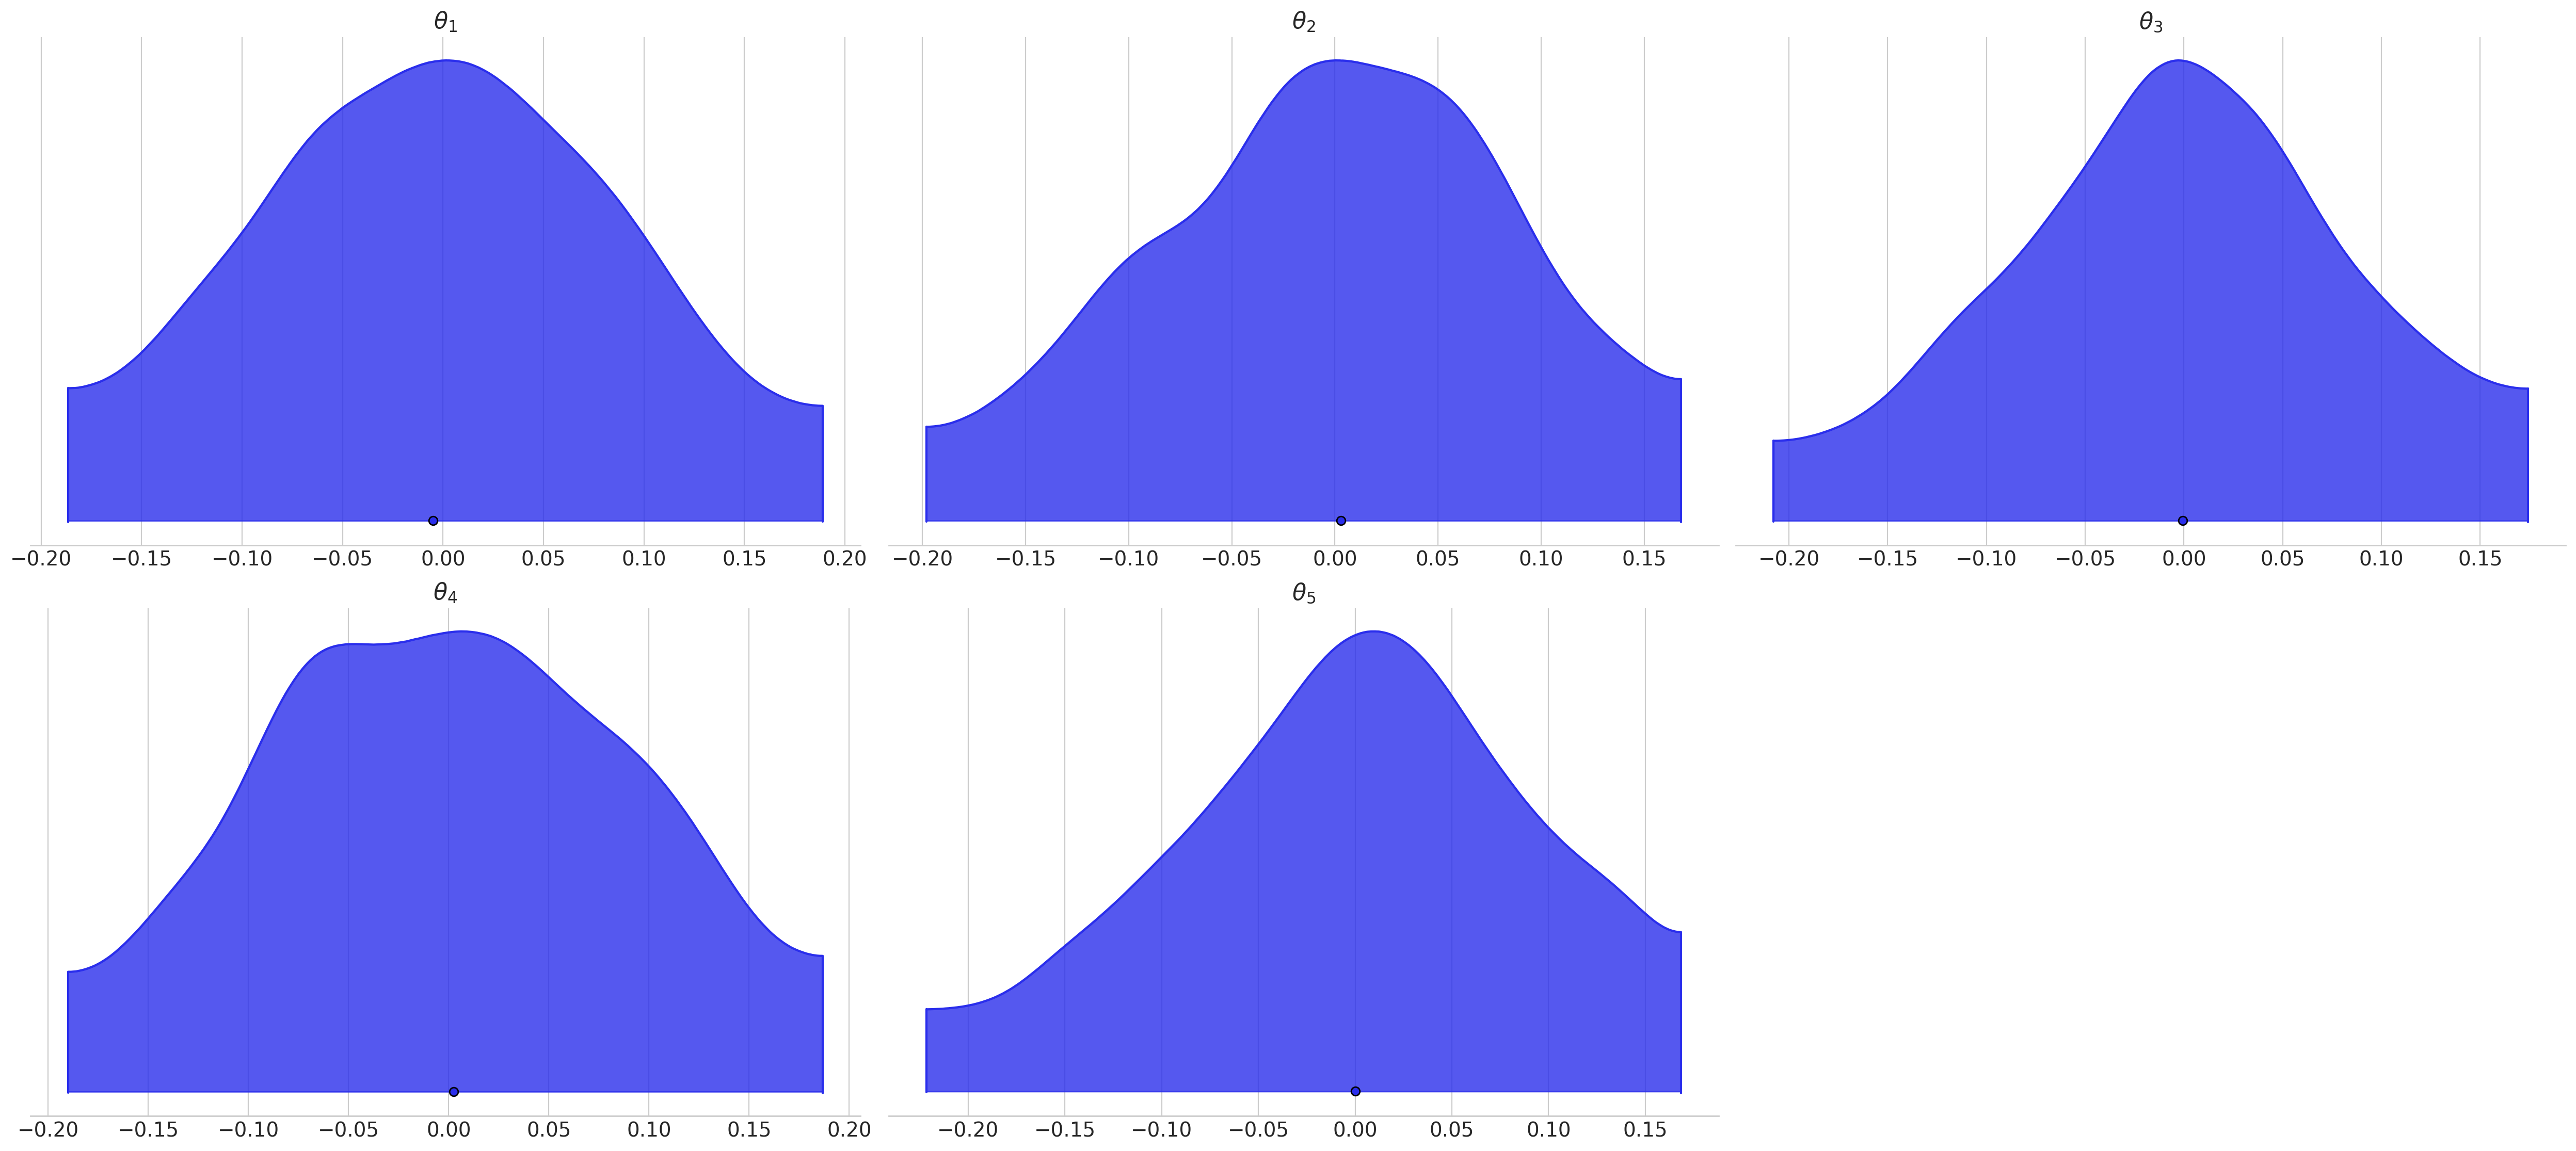

array([[<Axes: title={'center': '$\\theta_{1}$'}>,
        <Axes: title={'center': '$\\theta_{2}$'}>,
        <Axes: title={'center': '$\\theta_{3}$'}>],
       [<Axes: title={'center': '$\\theta_{4}$'}>,
        <Axes: title={'center': '$\\theta_{5}$'}>, <Axes: >]],
      dtype=object)

In [9]:
theta_labels = get_labels_for_var("\\theta", ndim)
theta_dataset = tensor_to_dataset(theta_labels, theta)

plot_kwargs = dict(shade=0.8, show=True)  # grid=(5, 2), figsize=(12, 20), show=True)
az.plot_density(theta_dataset, var_names=theta_labels, **plot_kwargs)

Density plots for the generated data:

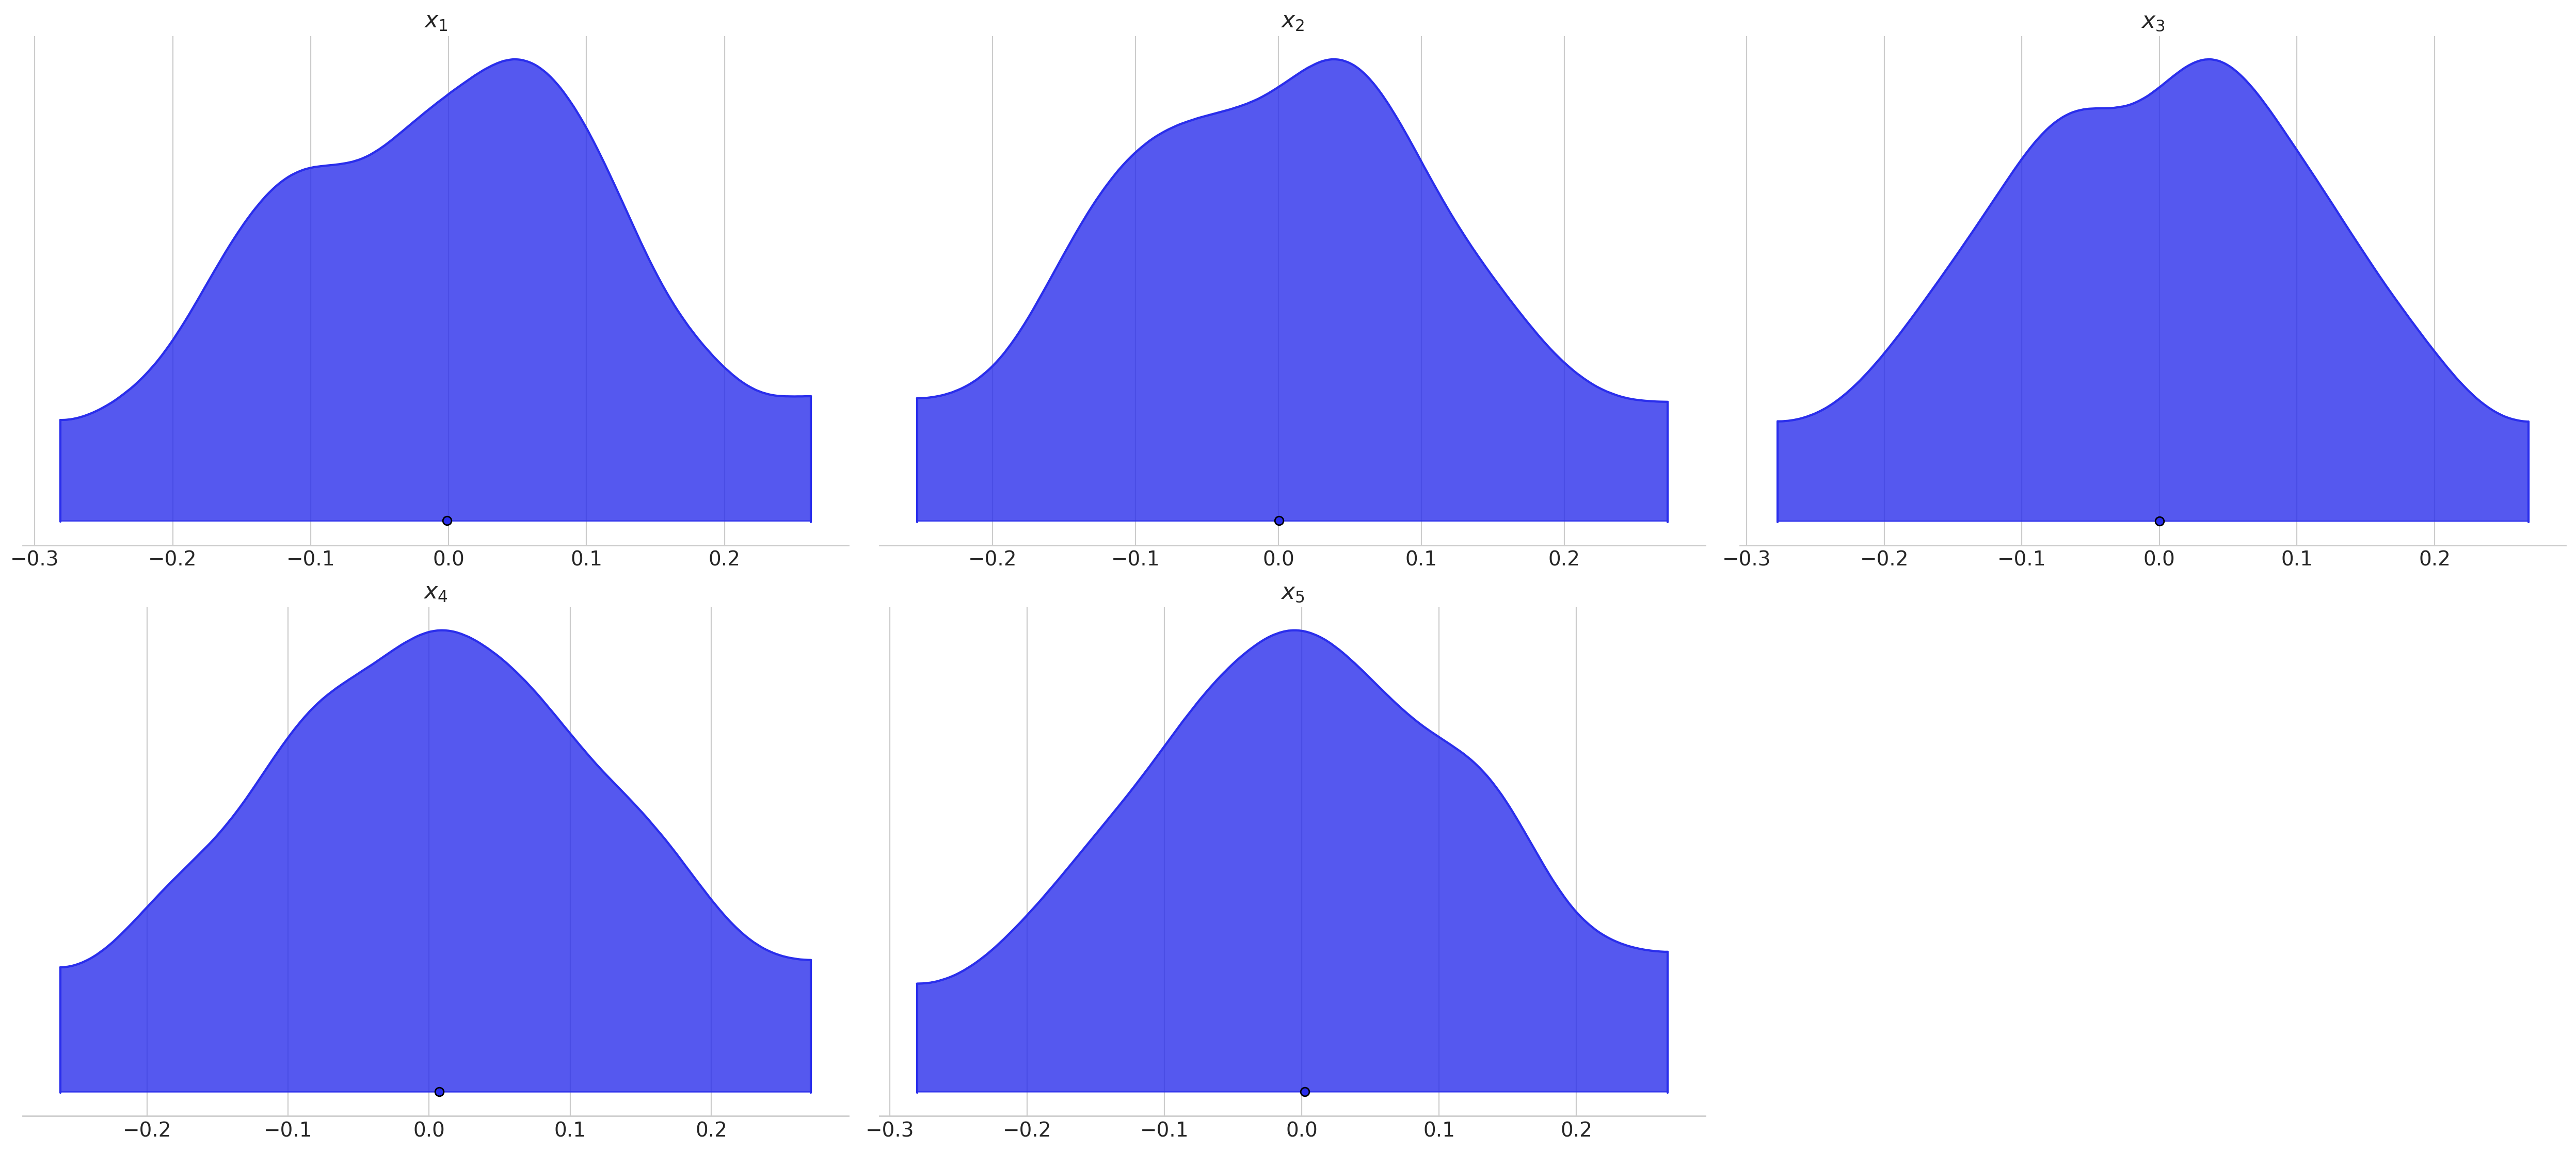

array([[<Axes: title={'center': '$x_{1}$'}>,
        <Axes: title={'center': '$x_{2}$'}>,
        <Axes: title={'center': '$x_{3}$'}>],
       [<Axes: title={'center': '$x_{4}$'}>,
        <Axes: title={'center': '$x_{5}$'}>, <Axes: >]], dtype=object)

In [10]:
x_labels = get_labels_for_var("x", ndim)
x_dataset = tensor_to_dataset(x_labels, x)

az.plot_density(x_dataset, var_names=x_labels, **plot_kwargs)

The output of prior + simulator is the set of samples

$$\{(\boldsymbol{\theta}_i, \boldsymbol{x}_i)\},$$

for $i=1, \ldots, N_{sim}$. This will be the data used for the training and validation of the neural network, which is are both taken care of by `sbi`. Higher simulation budgets $N_{sim}$ increase the training time of the network, but normally yield better approximations for the true posterior - although the scaling is not expected to be linear.

### Simulator sanity-checks

Let us fix a fiducial $\boldsymbol{\theta}_0$ and use it as input to our simulator many times to get independent samples of $\boldsymbol{x} \sim p(\boldsymbol{x} | \boldsymbol{\theta}_0)$, and see if we recover the expected normal distribution centered around $\boldsymbol{\theta}_0$:

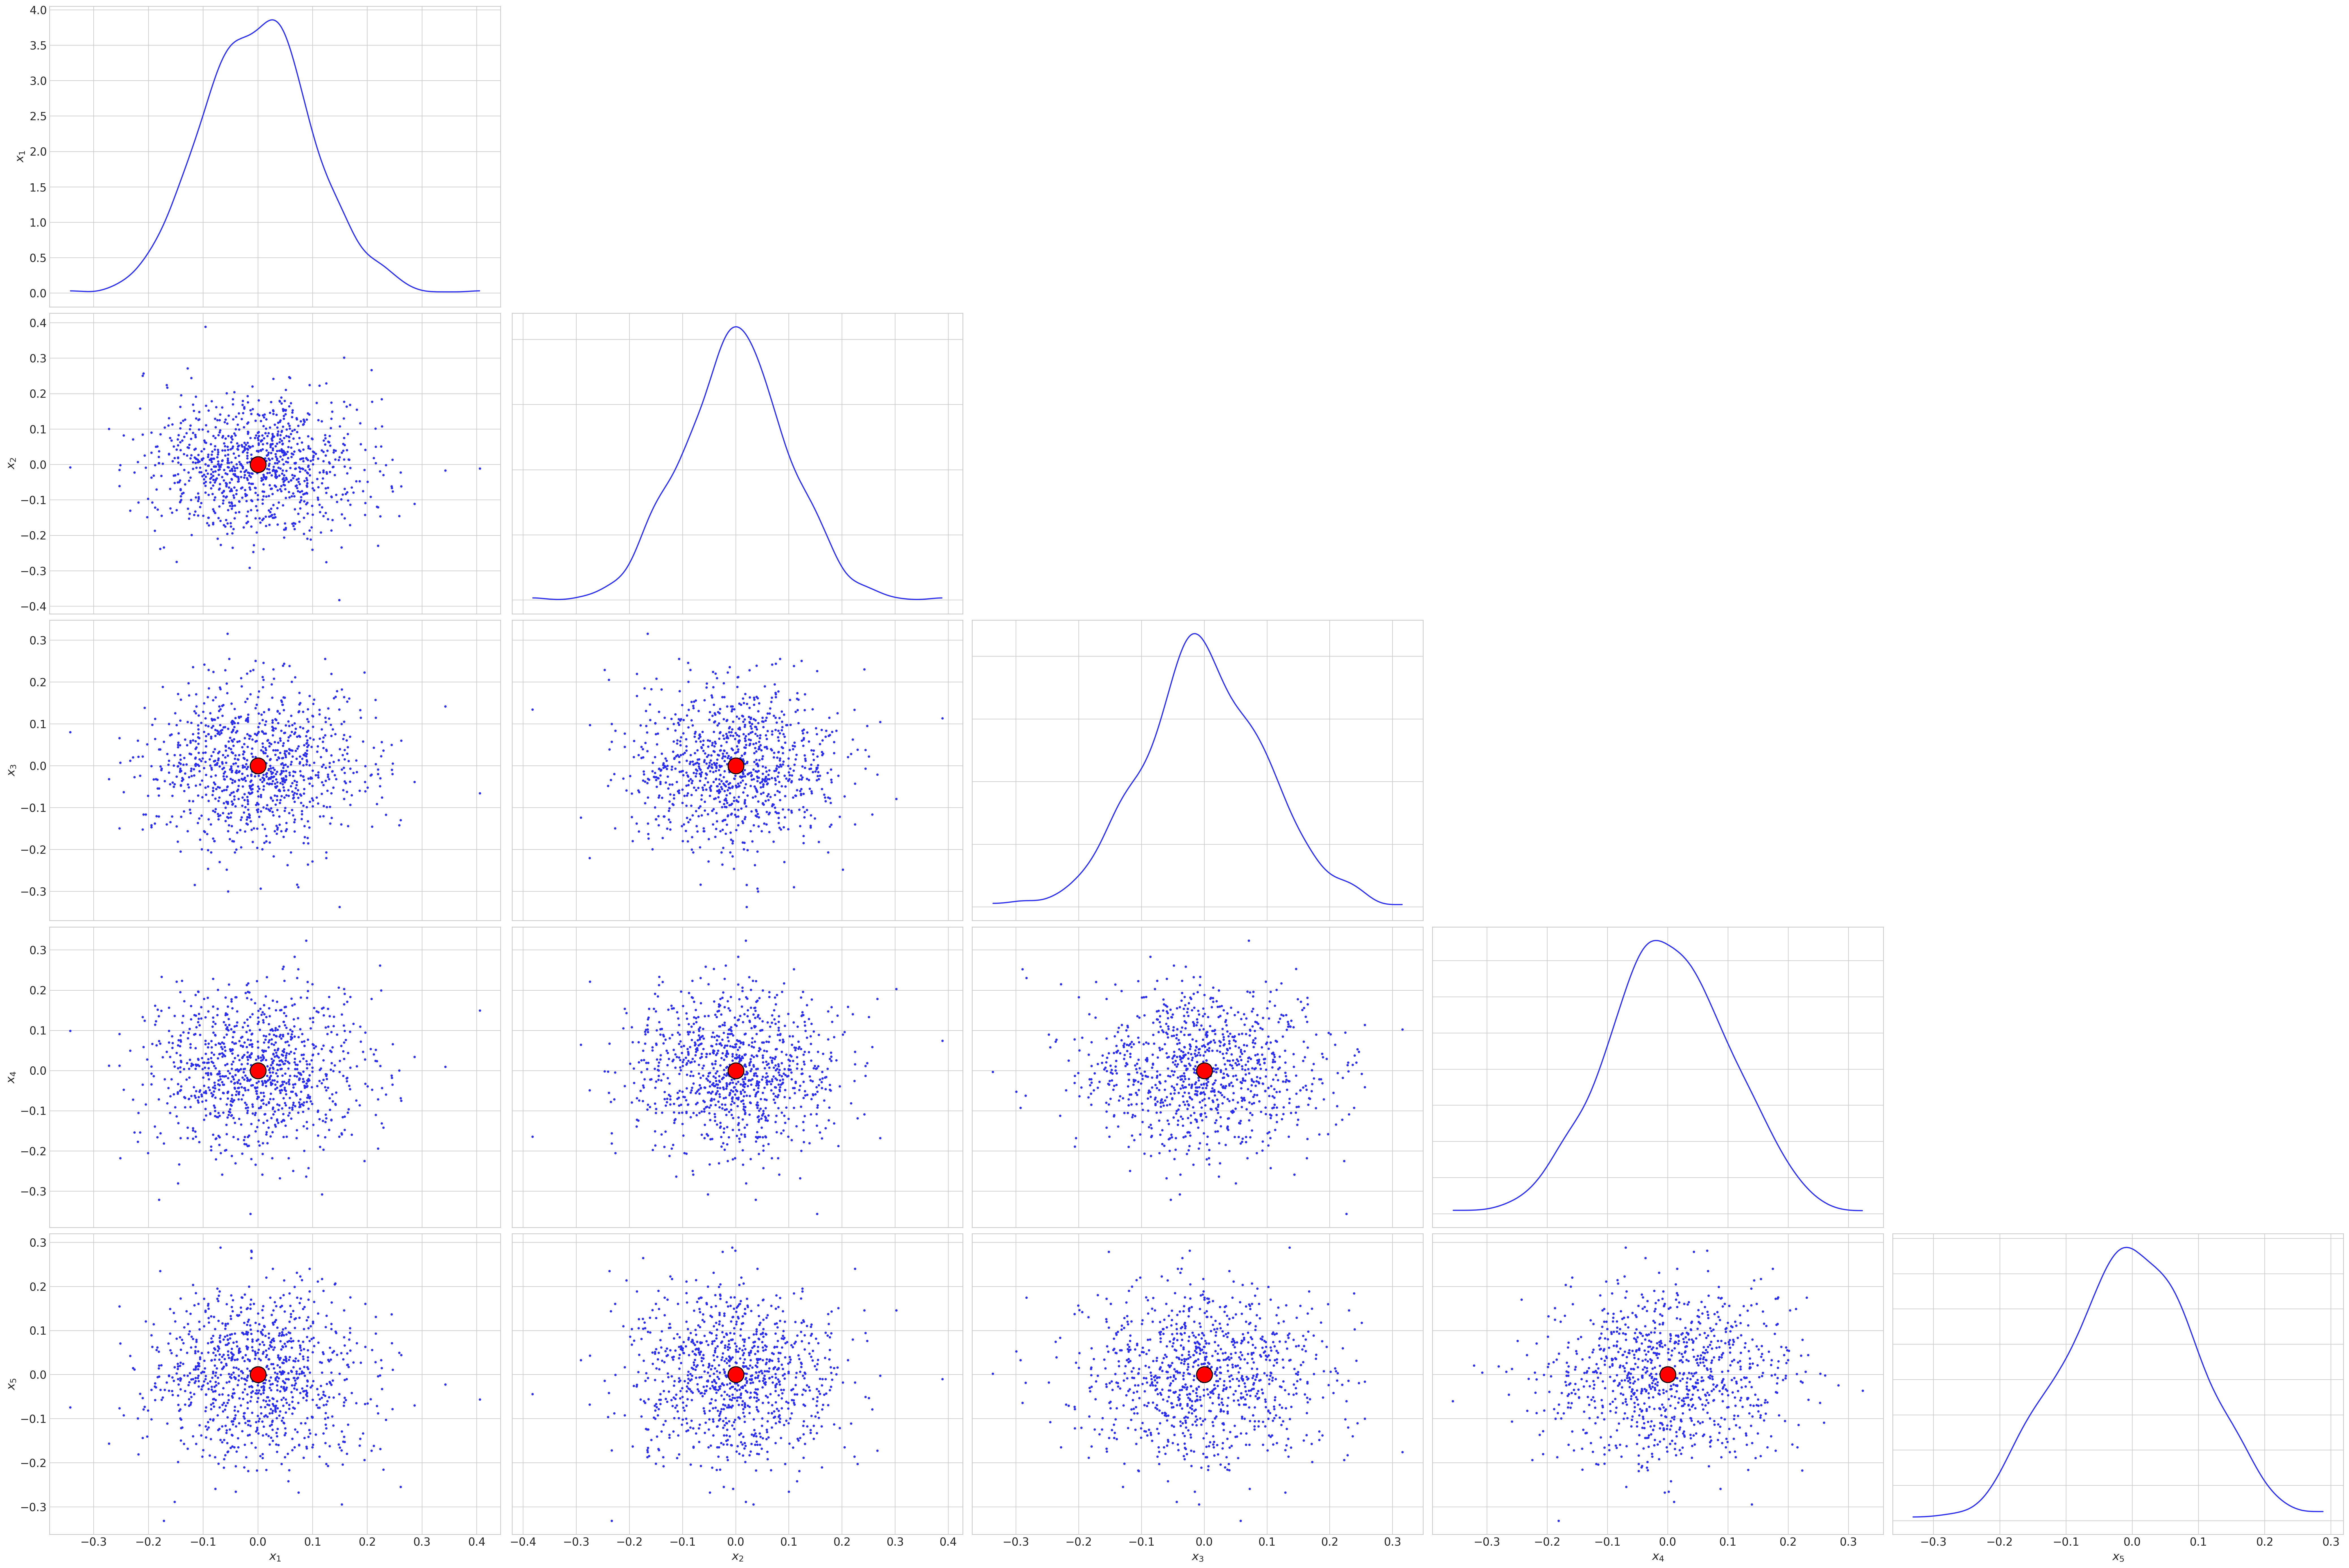

In [11]:
theta_0 = torch.zeros(1000, ndim)
x_of_theta_0 = simulator(theta_0)
x_labels = get_labels_for_var("x", ndim)


def plot_corner(labels, samples, truths):
    dataset = tensor_to_dataset(labels, samples)
    reference_values = tensor_to_dataset(labels, truths)
    with az.rc_context({"plot.max_subplots": ndim**2 + 1}):
        _ = az.plot_pair(
            dataset,
            var_names=labels,
            marginals=True,
            reference_values=reference_values,
            reference_values_kwargs={"ls": "dotted", "markersize": 20, "color": "red"},
        )


plot_corner(x_labels, x_of_theta_0, theta_0)

Fixing nominal values:

In [12]:
%precision 3
fiducial_theta, fiducial_x = simulate_for_sbi(simulator, prior, 1)
{
    "Fiducial theta": fiducial_theta.squeeze().tolist(),
    "Data point": fiducial_x.squeeze().tolist(),
}

{'Fiducial theta': [0.122, -0.130, 0.202, -0.004, -0.035],
 'Data point': [-0.036, -0.246, 0.333, -0.174, -0.120]}

## Performing Simulation-based inference

### Neural Posterior Estimation (NPE)

Neural Posterior Estimation (NPE) consists of training a neural density estimator with a simulated dataset to directly approximate the posterior $p(\boldsymbol{\theta} | \boldsymbol{x})$. One advantage of this approach is that one can directly sample from the amortized approximation of the posterior, without having to perform extra MCMC steps.

The estimator is trained to minimize the loss function

$$
    \mathcal{L}(\boldsymbol{\phi}) = \mathbb{E}_{\boldsymbol{\theta} \sim p(\boldsymbol{\theta})} \mathbb{E}_{\boldsymbol{x} \sim p(\boldsymbol{x} | \boldsymbol{\theta})} \left[-\log q_{\boldsymbol{\phi}} (\boldsymbol{\theta} | \boldsymbol{x}) \right],
$$

where $\boldsymbol{\phi}$ is the parameter vector of the neural network. The loss function attains a minimum at $q_{\boldsymbol{\phi}} (\boldsymbol{\theta} | \boldsymbol{x}) = p(\boldsymbol{\theta} | \boldsymbol{x})$. Indeed, by writing it explicity,

$$
    \mathcal{L} = -\iint d\boldsymbol{\theta} d\boldsymbol{x}  p(\boldsymbol{\theta}) p(\boldsymbol{x} | \boldsymbol{\theta}) \log q_{\boldsymbol{\phi}}(\boldsymbol{\theta} | \boldsymbol{x}),
$$

one can apply Bayes' theorem and commute the integrals to write
$$
\begin{split}
    \mathcal{L} &= -\int d\boldsymbol{x} p(\boldsymbol{x}) \int d\boldsymbol{\theta} p(\boldsymbol{\theta} | \boldsymbol{x}) \log q_{\boldsymbol{\phi}}(\boldsymbol{\theta} | \boldsymbol{x}) \\
    &=D_{KL}\left[q_{\boldsymbol{\phi}}(\boldsymbol{\theta} | \boldsymbol{x}) \parallel p(\boldsymbol{\theta} | \boldsymbol{x}) \right] + \rm{const},
\end{split}
$$
where the first term is recognized to be the conditional relative entropy between $q_{\boldsymbol{\phi}}(\boldsymbol{\theta} | \boldsymbol{x})$ and the true posterior distribution $p(\boldsymbol{\theta} | \boldsymbol{x})$, which is zero if and only if the two measures are equal almost everywhere, and positive otherwise. The additional constant term does not depend on  $q_{\boldsymbol{\phi}}$ and equals

$$
    \mathbb{E}_{\boldsymbol{\theta} \sim p(\boldsymbol{\theta})} \mathbb{E}_{\boldsymbol{x} \sim p(\boldsymbol{x} | \boldsymbol{\theta})} \left[-\log p(\boldsymbol{\theta} | \boldsymbol{x}) \right].
$$

A common implementation of the estimator $q_{\boldsymbol{\phi}}(\boldsymbol{\theta} | \boldsymbol{x})$ is with a *normalizing flow*. In a nutshell, a normalizing flow is based on the idea of a set of invertible and differentible transformations between two distributions. If we consider our generative model as a series of transformations from a simple distribution (e.g. a *prior*) to a complex distribution (e.g. the posterior), the normalizing flow will attempt to learn the *inverse* transformations. For a more formal discussion on the subject, we refer the reader to [this review paper](https://arxiv.org/abs/1908.09257).

In [13]:
from sbi.inference import SNPE

inference = SNPE(prior=prior)
inference.append_simulations(theta, x)

We train the neural network with the `train` method. A number of arguments can be specified to tune the training hyperparameters (see the [docs](https://sbi-dev.github.io/sbi/reference/#sbi.inference.snpe.snpe_c.SNPE_C.train)), but we will stick to their default values here.

In [14]:
%%time
density_estimator = inference.train()

 Neural network successfully converged after 56 epochs.CPU times: user 23.8 s, sys: 874 ms, total: 24.6 s
Wall time: 15.7 s


The output of the training is the density estimator, which we can use to build the posterior:

In [15]:
posterior = inference.build_posterior(density_estimator=density_estimator)

Now that we have built an estimator for the posterior probability $p(\boldsymbol{\theta} | \boldsymbol{x})$, we draw a fiducial pair $(\boldsymbol{\theta}_f, \boldsymbol{x}_f)$ to serve as our observed data. In the last line, we use the `.sample` method to sample from the approximate posterior density.

In [16]:
%%time
num_samples = 1000
samples_from_npe = posterior.sample((num_samples,), x=fiducial_x)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 120 ms, sys: 9.42 ms, total: 129 ms
Wall time: 127 ms


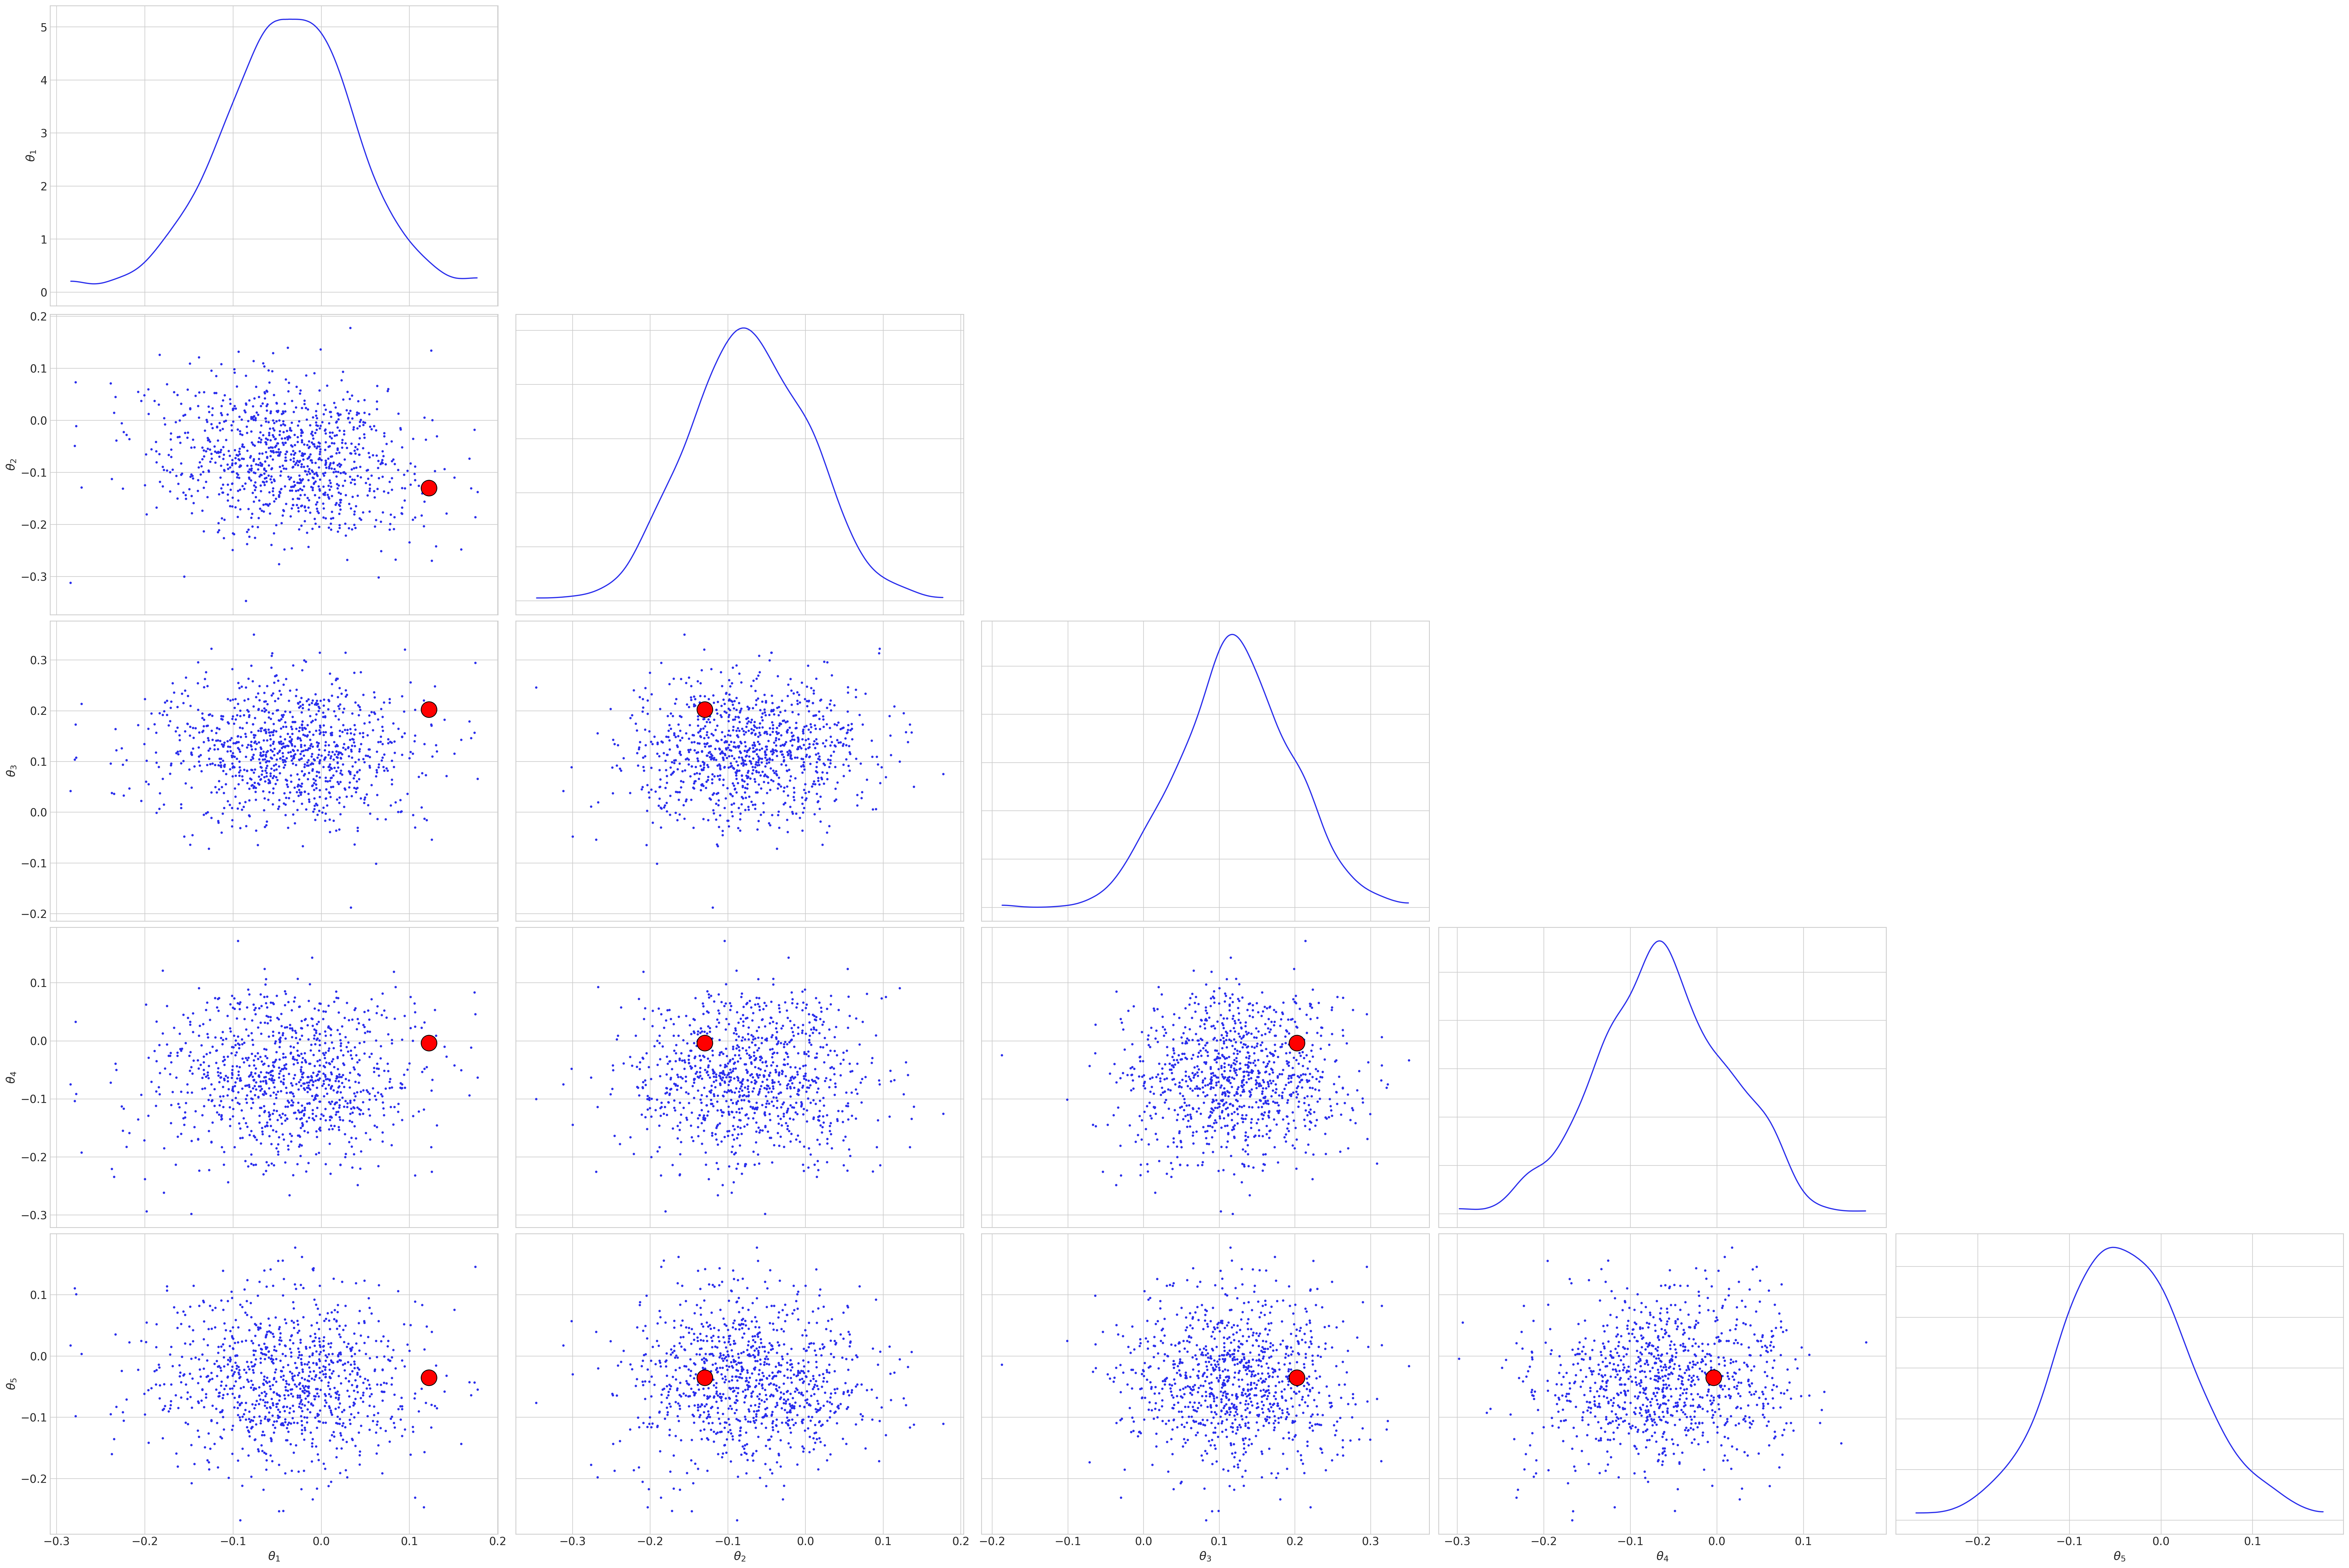

In [17]:
plot_corner(theta_labels, samples_from_npe, fiducial_theta.squeeze())

## Neural Likelihood Estimation (NLE)

Neural Likelihood Estimation (NLE) shares the same philosophy of NPE, but tries to learn the likelihood $p(\boldsymbol{x} | \boldsymbol{\theta})$ instead of the posterior. Let us redo the calculations with this method.

In [18]:
from sbi.inference import SNLE

inference = SNLE(prior=prior)
inference.append_simulations(theta, x)

In [19]:
%%time
density_estimator = inference.train()

 Neural network successfully converged after 35 epochs.CPU times: user 14.1 s, sys: 278 ms, total: 14.4 s
Wall time: 8.16 s


The differences between NPE and NLE start to show once we have trained the neural network and want to build the posterior. The density estimator approximates the likelihood $p(\boldsymbol{x} | \boldsymbol{\theta})$, therefore we need an additional computational step to obtain samples from the posterior $p(\boldsymbol{x} | \boldsymbol{\theta}) p(\boldsymbol{\theta})$. This may be achieved with standard sampling methods, such as MCMC, rejection sampling, importance sampling, etc. In the context of our toy model, the procedure may seem redundant, as we know the analytical form of the likelihood. However, as we consider more complex models, for which the form of the likelihood is intractable, the SBI approach allows us to relax any analytical approximations (e.g. gaussian distribution) and let the neural network itself learn the non-linear mapping between $\boldsymbol{\theta}$ and $\boldsymbol{x}$.

We list below some of the sampling options implemented in the `sbi` package:

- MCMC
    - Custom implementation of slice sampling
    - Hamiltonian Monte Carlo (HMC or NUTS) via [pyro](https://pyro.ai/)
    - Hamiltonian Monte Carlo (HMC or NUTS) via [PyMC](https://www.pymc.io/welcome.html)
- Rejection sampling
- Importance sampling
- Variational inference

In [20]:
posterior = inference.build_posterior(
    density_estimator=density_estimator, sample_with="mcmc"
)

/Users/bernardoveronese/miniconda3/envs/sbibench/lib/python3.10/site-packages/sbi/inference/posteriors/mcmc_posterior.py:114: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Generating samples with MCMC:

In [21]:
%%time
samples_from_nle = posterior.sample((num_samples,), x=fiducial_x)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

CPU times: user 1min 17s, sys: 884 ms, total: 1min 18s
Wall time: 1min 24s


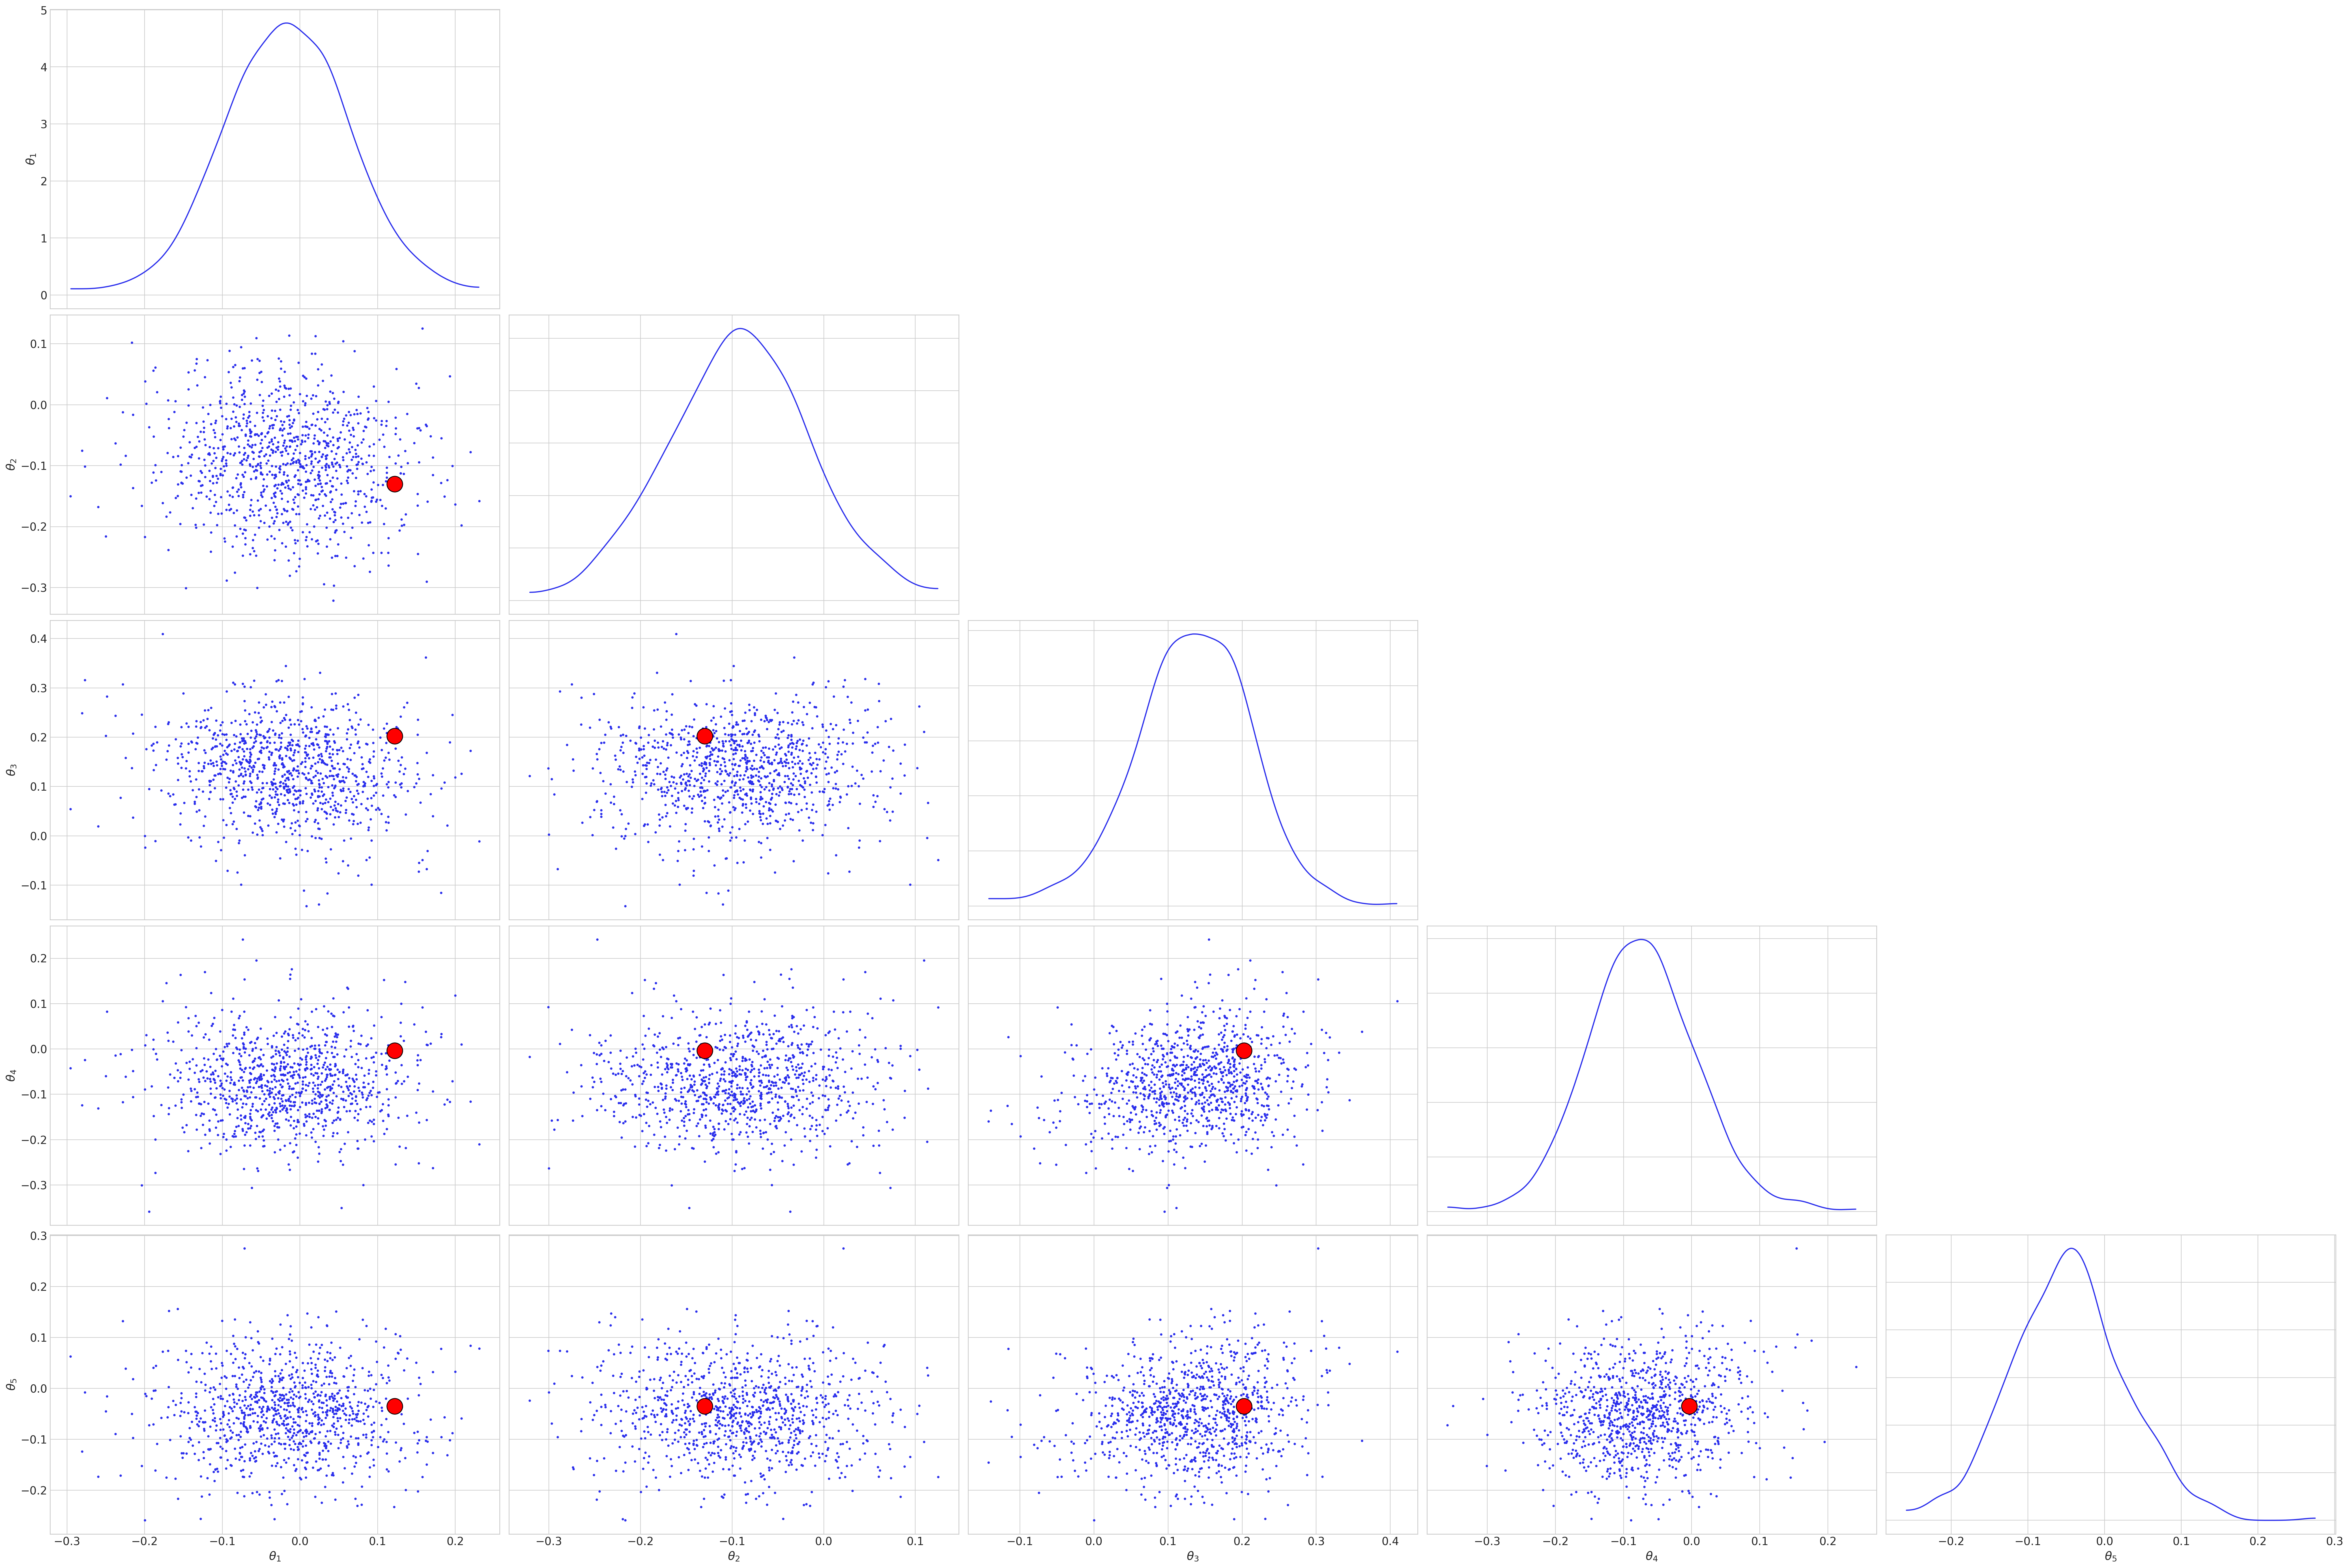

In [22]:
plot_corner(theta_labels, samples_from_nle, fiducial_theta.squeeze())

## Neural Ratio Estimation (NRE)

As we have seen, the output of prior + simulator is the array of pairs $(\boldsymbol{x}_i, \boldsymbol{\theta}_i)$ is drawn from the joint distribution

$$
    (\boldsymbol{x}_i, \boldsymbol{\theta}_i) \sim p(\boldsymbol{x}, \boldsymbol{\theta}) = p(\boldsymbol{x} | \boldsymbol{\theta})p(\boldsymbol{\theta})
$$

We now consider the shuffled pairs $(\boldsymbol{x}_i, \boldsymbol{\theta}_j)$, where $\boldsymbol{x}_i$ is the output of the forward-modeled input $\boldsymbol{\theta}_i, \, i \neq j$. These pairs are sampled from the product distribution

$$
    (\boldsymbol{x}_i, \boldsymbol{\theta}_j) \sim p(\boldsymbol{x}) p(\boldsymbol{\theta})
$$

The idea of NRE is to train a classifier to learn the ratio

$$
    r(\boldsymbol{x}, \boldsymbol{\theta}) \equiv \frac{p(\boldsymbol{x}, \boldsymbol{\theta})}{p(\boldsymbol{x})p(\boldsymbol{\theta})} = \frac{p(\boldsymbol{x} | \boldsymbol{\theta})}{p(\boldsymbol{x})}, 
$$

which is equal to the likelihood-to-evidence ratio. The application of Bayes' theorem makes the connection between $r(\boldsymbol{x}, \boldsymbol{\theta})$ and the Bayesian inverse problem:

$$
    r(\boldsymbol{x}, \boldsymbol{\theta}) = \frac{p(\boldsymbol{x}, \boldsymbol{\theta})}{p(\boldsymbol{x})} = \frac{p(\boldsymbol{\theta} | \boldsymbol{x})}{p(\boldsymbol{\theta})}.
$$

In other words, $r(\boldsymbol{x}, \boldsymbol{\theta})$ equals the posterior-to-prior ratio. Therefore, one can get samples from the posterior distribution of $\boldsymbol{\theta}$ from the approximate knowledge of $r(\boldsymbol{x}, \boldsymbol{\theta})$ and prior samples from $\boldsymbol{\theta}$.

More specifically, the binary classifier $d_{\boldsymbol{\phi}} (\boldsymbol{x}, \boldsymbol{\theta})$ with learnable parameters $\boldsymbol{\phi}$ is trained to distinguish the $(\boldsymbol{x}_i, \boldsymbol{\theta}_i)$ pairs sampled from the joint distribution from their shuffled counterparts. We label pairs with a variable $y$, such that $y=1$ refers to joint pairs, and $y=0$ to shuffled pairs. The classifier is trained to approximate

\begin{equation*}
\begin{split}
    d_{\boldsymbol{\phi}} (\boldsymbol{x}, \boldsymbol{\theta}) &\approx p(y=1 | \boldsymbol{x}, \boldsymbol{\theta})\\
    &= \frac{p(\boldsymbol{x}, \boldsymbol{\theta} | y = 1) p(y = 1)}{p(\boldsymbol{x}, \boldsymbol{\theta} | y = 0) p(y = 0) + p(\boldsymbol{x}, \boldsymbol{\theta} | y = 1) p(y = 1)}\\
    &= \frac{p(\boldsymbol{x}, \boldsymbol{\theta})}{p(\boldsymbol{x})\boldsymbol{\theta} + p(\boldsymbol{x}, \boldsymbol{\theta})}\\
    &= \frac{r(\boldsymbol{x}, \boldsymbol{\theta)}}{1 + r(\boldsymbol{x}, \boldsymbol{\theta)}},
\end{split}
\end{equation*}

where we used $p(y=0)=p(y=1)=0.5$.

The classifier learns the parameters $\boldsymbol{\phi}$ by minimizing the binary-cross entropy, defined as

$$
    L(d_{\boldsymbol{\phi}}) = - \int d\boldsymbol{\theta} \int d\boldsymbol{x} p(\boldsymbol{x}, \boldsymbol{\theta})\log d_{\boldsymbol{\phi}}(\boldsymbol{x}, \boldsymbol{\theta}) - p(\boldsymbol{x})\boldsymbol{\theta}\log(1-d_{\boldsymbol{\phi}}(\boldsymbol{x}, \boldsymbol{\theta}))
$$

In [23]:
from sbi.inference import SNRE

inference = SNRE(prior=prior)
inference.append_simulations(theta, x)

In [24]:
%%time 
density_estimator = inference.train()

 Neural network successfully converged after 48 epochs.CPU times: user 9.79 s, sys: 302 ms, total: 10.1 s
Wall time: 6.18 s


In [25]:
%%time 
posterior = inference.build_posterior(
    density_estimator=density_estimator, sample_with="mcmc"
)
samples_from_nre = posterior.sample((num_samples,), x=fiducial_x)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

CPU times: user 35.5 s, sys: 670 ms, total: 36.2 s
Wall time: 47.7 s


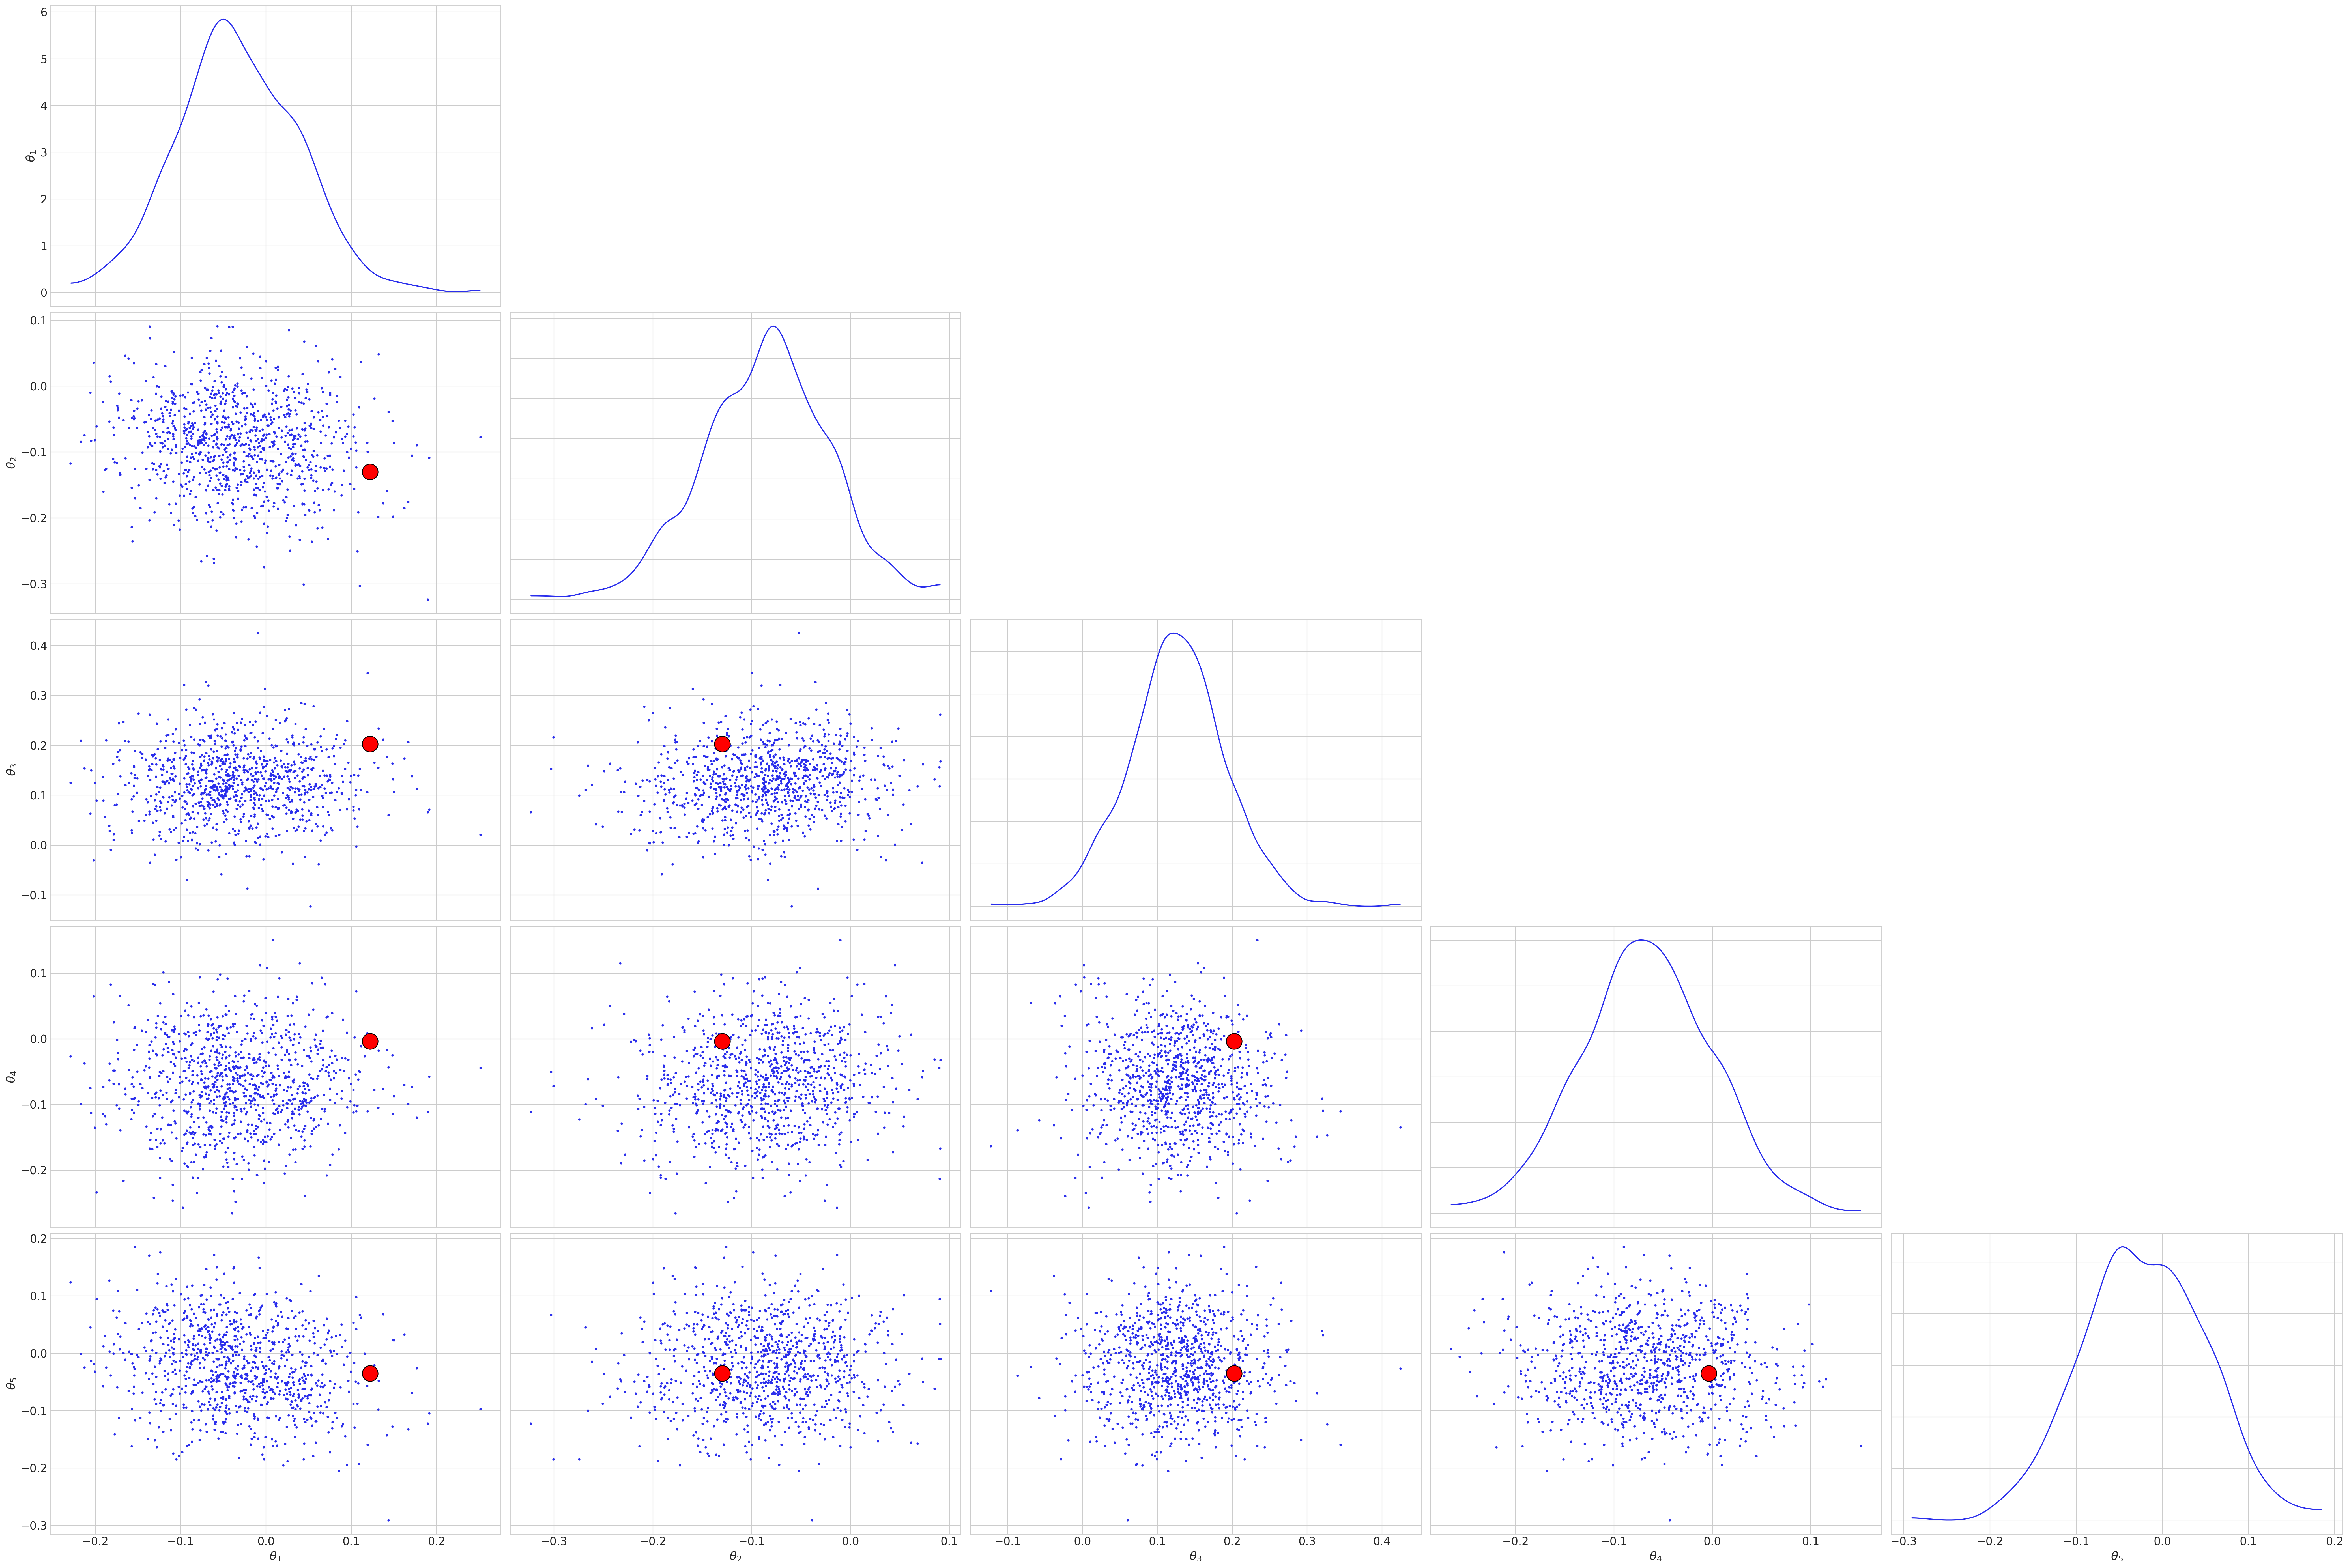

In [26]:
plot_corner(theta_labels, samples_from_nre, fiducial_theta.squeeze())

## Analyzing our results

For comparison, we draw samples from the true posterior:

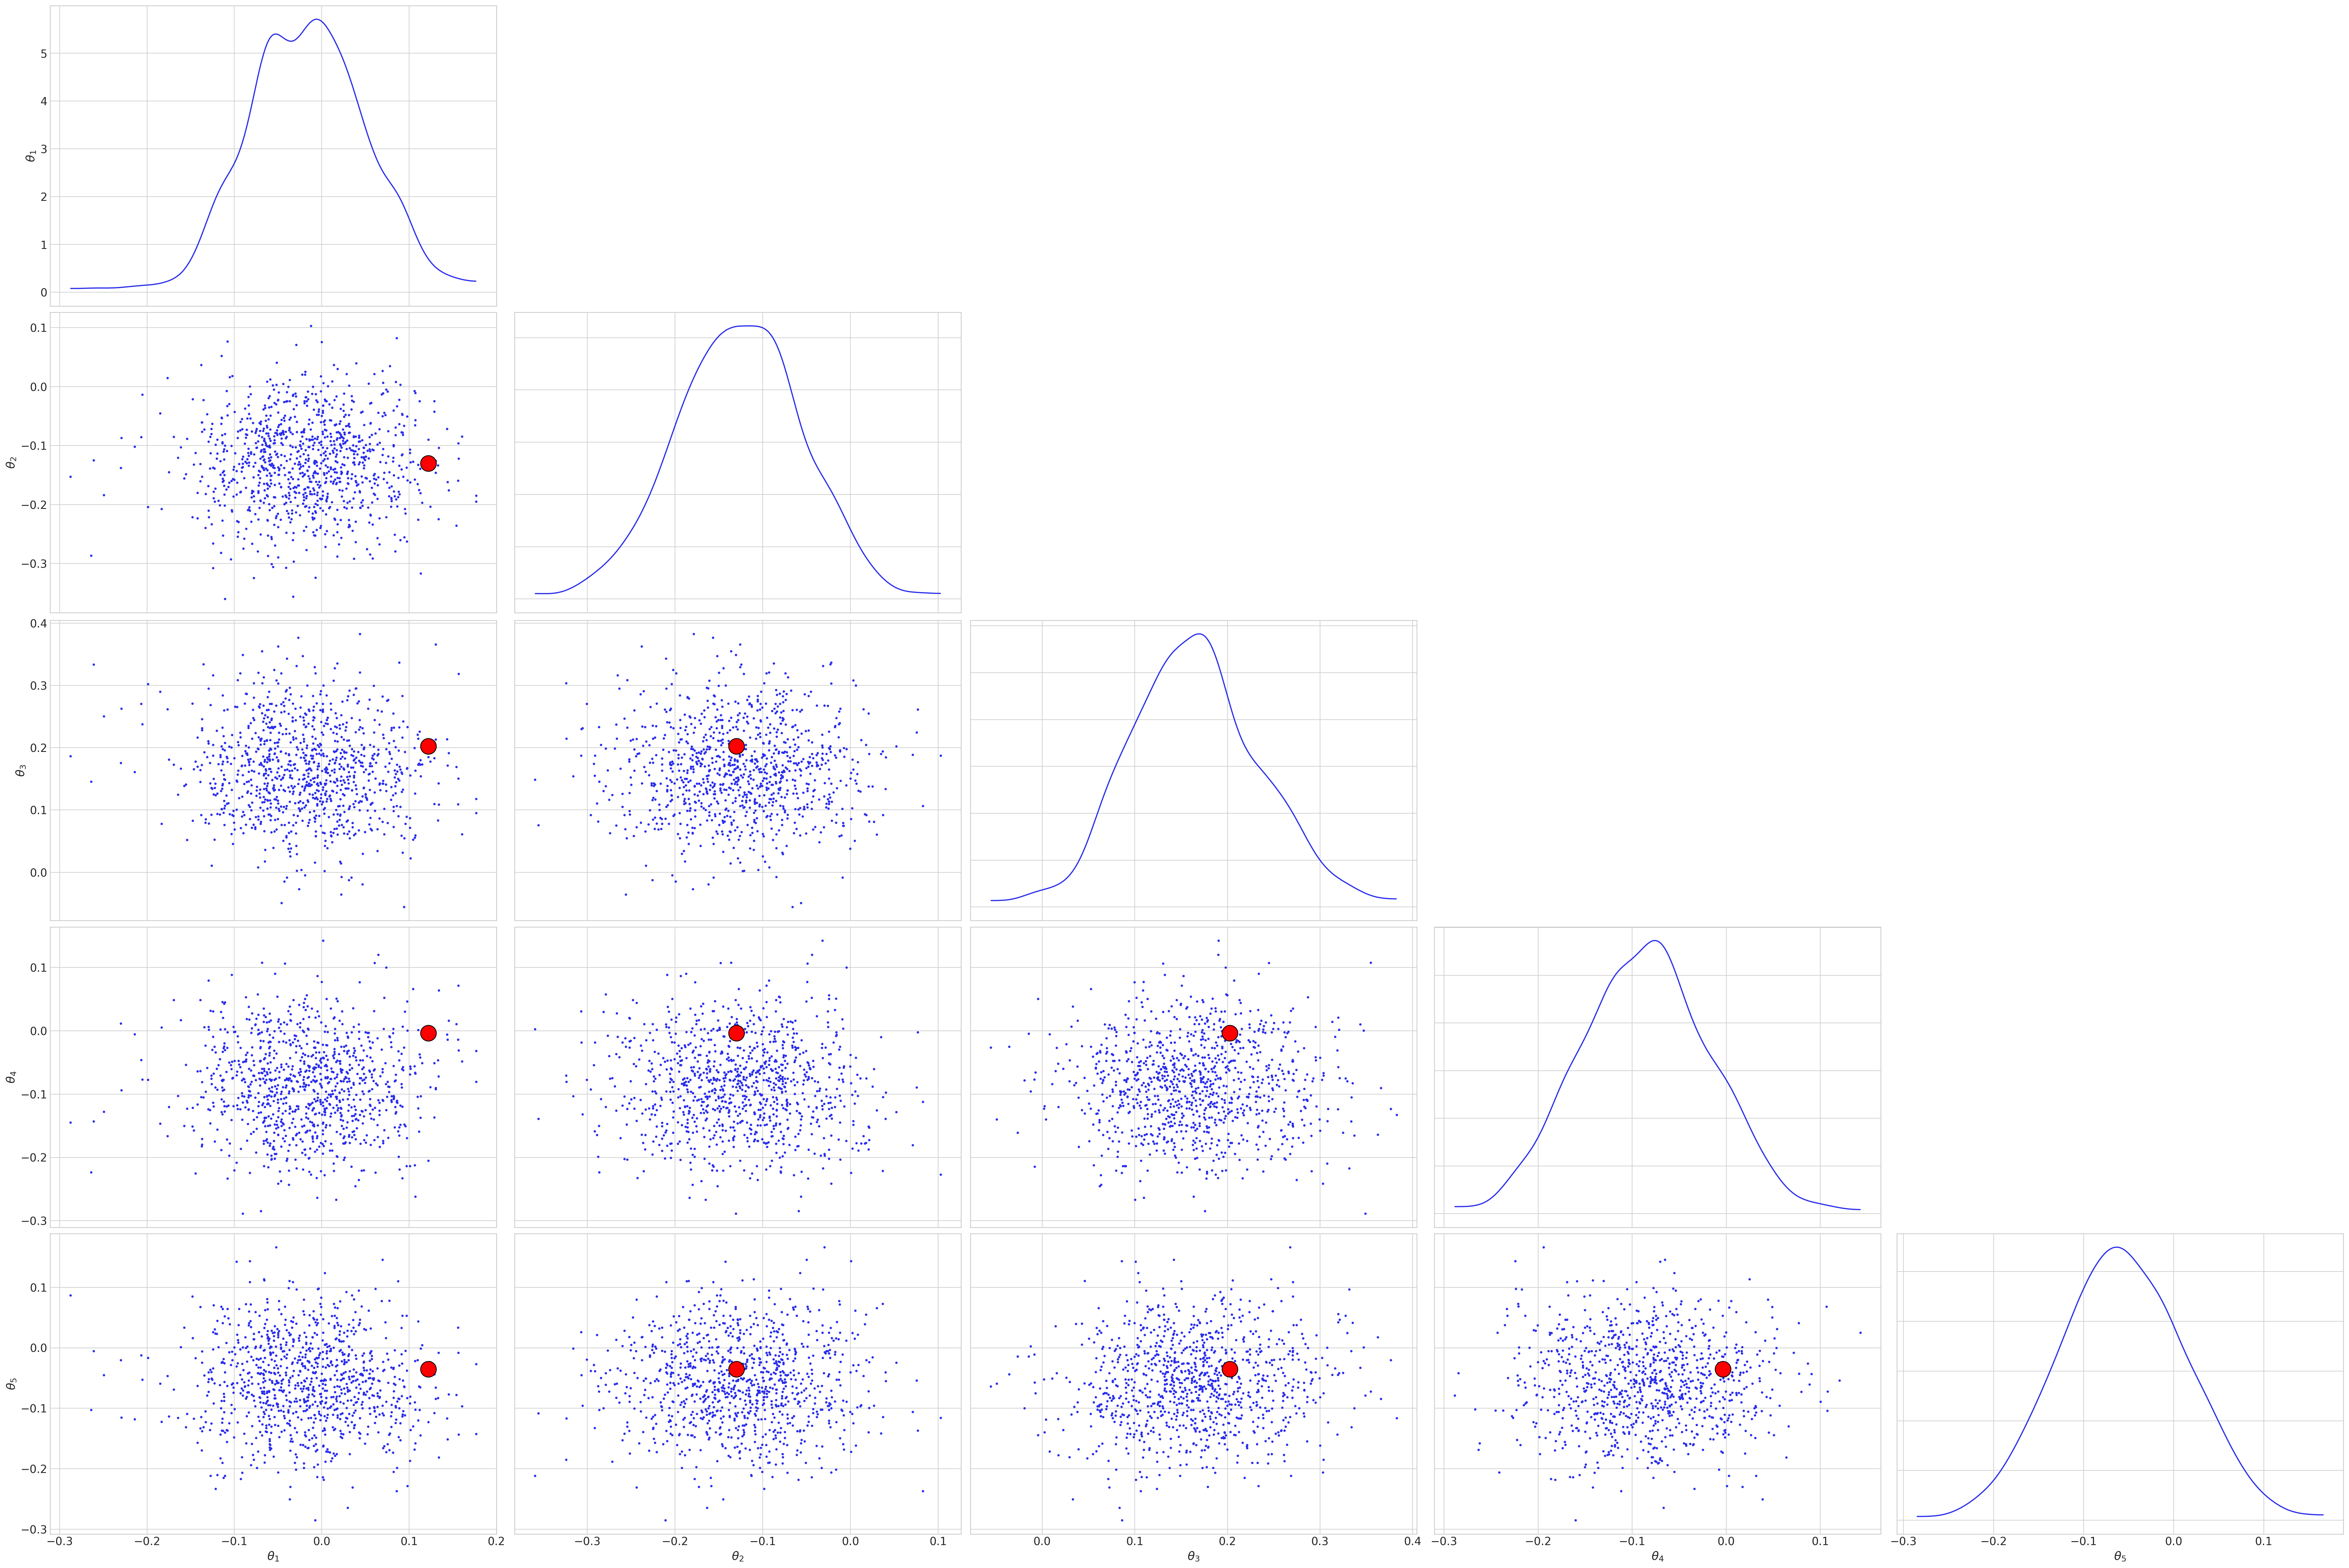

In [27]:
samples_from_true_posterior = get_true_posterior_samples(num_samples, fiducial_x)
plot_corner(theta_labels, samples_from_true_posterior, fiducial_theta.squeeze())

We validate our results using the C2ST metric, where a classifier is trained to distinguish samples of the true posterior from samples of the estimated posterior and returns a score between 0.5 and 1. If the samples are indistinguishable, the classification performance should be random, and the returned score is 0.5. Higher scores indicate that the classifier is better able to learn to distinguish between the two sample populations.

In [28]:
from sbi.utils.metrics import c2st

c2st_scores = dict(
    zip(
        ("NPE", "NLE", "NRE"),
        (
            c2st(samples, samples_from_true_posterior, seed=seed)
            for samples in (samples_from_npe, samples_from_nle, samples_from_nre)
        ),
    )
)
print(c2st_scores)

{'NPE': tensor([0.6960]), 'NLE': tensor([0.6160]), 'NRE': tensor([0.6690])}


## References

[1]: Cranmer, Kyle, Johann Brehmer, and Gilles Louppe. "The frontier of simulation-based inference." Proceedings of the National Academy of Sciences 117.48 (2020): 30055-30062.

[2]: Tejero-Cantero, Alvaro, et al. "SBI--A toolkit for simulation-based inference." arXiv preprint arXiv:2007.09114 (2020).

[3]: Kobyzev, Ivan, Simon JD Prince, and Marcus A. Brubaker. "Normalizing flows: An introduction and review of current methods." IEEE transactions on pattern analysis and machine intelligence 43.11 (2020): 3964-3979.

[4]: Lueckmann, Jan-Matthis, et al. "Benchmarking simulation-based inference." International conference on artificial intelligence and statistics. PMLR, 2021.